In [41]:

import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Load data
df = pd.read_csv('../data/cleaned_news_sentiment.csv')

In [ ]:
def clean_text_advanced(text):

    if pd.isna(text):
        return ""
    
    text = str(text)
    
    text = re.sub(r'<[^>]+>', '', text)
    
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    text = re.sub(r'\S+@\S+', '', text)
    
    text = re.sub(r'[!]{3,}', '!!', text)
    text = re.sub(r'[?]{3,}', '??', text)
    text = re.sub(r'[.]{3,}', '...', text)
    
    text = re.sub(r'[^\w\s.,!?;:\'-]', ' ', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = text.strip()
    
    return text


In [ ]:
print("Applying advanced text cleaning...")
df['description_clean'] = df['description_clean'].apply(clean_text_advanced)

df = df[df['description_clean'].str.len() > 0].reset_index(drop=True)

print(f"Dataset shape after cleaning: {df.shape}")

print("\n=== Class Distribution Analysis ===")
class_counts = df['sentiment'].value_counts()
print("Original class distribution:")
print(class_counts)
print(f"Class proportions:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count/len(df)*100:.2f}%")

Applying advanced text cleaning...
Dataset shape after cleaning: (1270, 4)

=== Class Distribution Analysis ===
Original class distribution:
sentiment
neutral     976
positive    217
negative     77
Name: count, dtype: int64
Class proportions:
neutral: 76.85%
positive: 17.09%
negative: 6.06%


(array([0, 1, 2]),
 [Text(0, 0, 'neutral'), Text(1, 0, 'positive'), Text(2, 0, 'negative')])

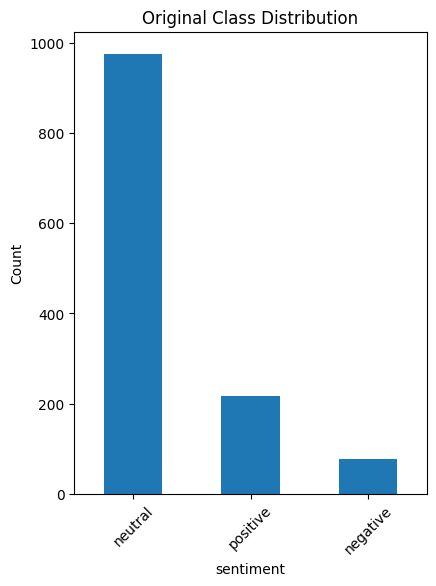

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar')
plt.title('Original Class Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)

In [ ]:
def balance_dataset(df, method='undersample', target_size=None):
    class_counts = df['sentiment'].value_counts()
    min_class_size = class_counts.min()
    max_class_size = class_counts.max()
    
    if method == 'undersample':
        balanced_dfs = []
        for sentiment in df['sentiment'].unique():
            class_df = df[df['sentiment'] == sentiment]
            sampled_df = class_df.sample(n=min_class_size, random_state=42)
            balanced_dfs.append(sampled_df)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
        
    elif method == 'oversample':
        target = target_size if target_size else max_class_size
        balanced_dfs = []
        
        for sentiment in df['sentiment'].unique():
            class_df = df[df['sentiment'] == sentiment]
            current_size = len(class_df)
            
            if current_size < target:
                additional_samples = target - current_size
                oversampled = class_df.sample(n=additional_samples, replace=True, random_state=42)
                balanced_df_class = pd.concat([class_df, oversampled], ignore_index=True)
            else:
                balanced_df_class = class_df.sample(n=target, random_state=42)
            
            balanced_dfs.append(balanced_df_class)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
        
    elif method == 'mixed':
        target = target_size if target_size else int(np.mean([min_class_size, max_class_size]))
        balanced_dfs = []
        
        for sentiment in df['sentiment'].unique():
            class_df = df[df['sentiment'] == sentiment]
            current_size = len(class_df)
            
            if current_size < target:
                additional_samples = target - current_size
                oversampled = class_df.sample(n=additional_samples, replace=True, random_state=42)
                balanced_df_class = pd.concat([class_df, oversampled], ignore_index=True)
            else:
                balanced_df_class = class_df.sample(n=target, random_state=42)
            
            balanced_dfs.append(balanced_df_class)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle


Applying mixed balancing...

Balanced class distribution:
sentiment
negative    526
positive    526
neutral     526
Name: count, dtype: int64
Balanced class proportions:
negative: 33.33%
positive: 33.33%
neutral: 33.33%


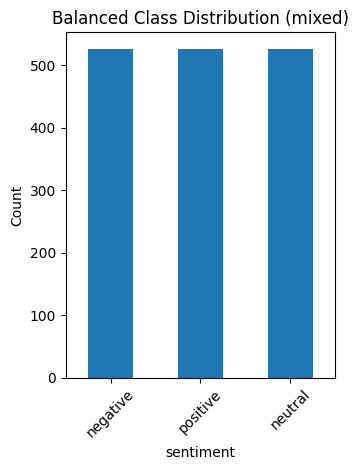

In [ ]:
# Apply data balancing
balance_method = 'mixed'
print(f"\nApplying {balance_method} balancing...")

df_balanced = balance_dataset(df, method=balance_method)

balanced_class_counts = df_balanced['sentiment'].value_counts()
print(f"\nBalanced class distribution:")
print(balanced_class_counts)
print(f"Balanced class proportions:")
for class_name, count in balanced_class_counts.items():
    print(f"{class_name}: {count/len(df_balanced)*100:.2f}%")

plt.subplot(1, 2, 2)
balanced_class_counts.plot(kind='bar')
plt.title(f'Balanced Class Distribution ({balance_method})')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Label encoding
label_encoder = LabelEncoder()
df_balanced['sentiment_encoded'] = label_encoder.fit_transform(df_balanced['sentiment'])

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print(f"\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df_balanced['sentiment_encoded']),
    y=df_balanced['sentiment_encoded']
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass weights: {class_weights_dict}")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['description_clean'].tolist(), 
    df_balanced['sentiment_encoded'].tolist(), 
    test_size=0.2, 
    random_state=42,
    stratify=df_balanced['sentiment_encoded']  # Ensure balanced split
)

print(f"\nTrain set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
    


Label mapping:
0: negative
1: neutral
2: positive

Class weights: {0: 1.0, 1: 1.0, 2: 1.0}

Train set size: 1262
Validation set size: 316


In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text_lengths = [len(tokenizer.encode(text, truncation=False)) for text in train_texts[:1000]]  # Sample for speed
avg_length = np.mean(text_lengths)
max_length = min(512, int(np.percentile(text_lengths, 95)))  # Use 95th percentile or 512, whichever is smaller

d:\aaa\PBL\Temp\modelpy\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [50]:
print(f"\nText length analysis:")
print(f"Average token length: {avg_length:.1f}")
print(f"95th percentile length: {max_length}")
print(f"Using max_length: {max_length}")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)



Text length analysis:
Average token length: 40.3
95th percentile length: 62
Using max_length: 62


In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)


In [ ]:
# Load model
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        if self.class_weights is not None:
            weight_tensor = torch.tensor([self.class_weights[i] for i in range(len(self.class_weights))], 
                                       dtype=torch.float32, device=labels.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=weight_tensor)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# pip install transformers==4.36.0 accelerate==0.25.0

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    seed=42
)

In [ ]:
trainer = WeightedTrainer(
    class_weights=class_weights_dict,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
print("\n=== Starting Training ===")
trainer.train()



=== Starting Training ===


  2%|▏         | 11/474 [00:02<01:58,  3.89it/s]

{'loss': 1.1499, 'learning_rate': 5e-06, 'epoch': 0.06}


  4%|▍         | 21/474 [00:05<01:56,  3.89it/s]

{'loss': 1.0816, 'learning_rate': 1e-05, 'epoch': 0.13}


  7%|▋         | 31/474 [00:08<01:53,  3.91it/s]

{'loss': 1.0248, 'learning_rate': 1.5e-05, 'epoch': 0.19}


  9%|▊         | 41/474 [00:10<01:51,  3.88it/s]

{'loss': 0.9798, 'learning_rate': 2e-05, 'epoch': 0.25}


 11%|█         | 51/474 [00:13<01:48,  3.90it/s]

{'loss': 0.9209, 'learning_rate': 2.5e-05, 'epoch': 0.32}


 13%|█▎        | 61/474 [00:15<01:45,  3.91it/s]

{'loss': 0.8003, 'learning_rate': 3e-05, 'epoch': 0.38}


 15%|█▍        | 71/474 [00:18<01:43,  3.90it/s]

{'loss': 0.7993, 'learning_rate': 3.5e-05, 'epoch': 0.44}


 17%|█▋        | 81/474 [00:20<01:41,  3.88it/s]

{'loss': 0.6979, 'learning_rate': 4e-05, 'epoch': 0.51}


 19%|█▉        | 91/474 [00:23<01:37,  3.92it/s]

{'loss': 0.7147, 'learning_rate': 4.5e-05, 'epoch': 0.57}


 21%|██▏       | 101/474 [00:25<01:37,  3.82it/s]

{'loss': 0.648, 'learning_rate': 5e-05, 'epoch': 0.63}


 23%|██▎       | 111/474 [00:28<01:33,  3.87it/s]

{'loss': 0.6623, 'learning_rate': 4.8663101604278076e-05, 'epoch': 0.7}


 26%|██▌       | 121/474 [00:31<01:31,  3.88it/s]

{'loss': 0.5348, 'learning_rate': 4.732620320855615e-05, 'epoch': 0.76}


 28%|██▊       | 131/474 [00:33<01:28,  3.87it/s]

{'loss': 0.6078, 'learning_rate': 4.598930481283423e-05, 'epoch': 0.82}


 30%|██▉       | 141/474 [00:36<01:26,  3.85it/s]

{'loss': 0.5606, 'learning_rate': 4.4652406417112304e-05, 'epoch': 0.89}


 32%|███▏      | 151/474 [00:38<01:23,  3.87it/s]

{'loss': 0.5293, 'learning_rate': 4.331550802139038e-05, 'epoch': 0.95}


 33%|███▎      | 158/474 [00:43<01:17,  4.09it/s]

{'eval_loss': 0.435414582490921, 'eval_runtime': 2.5766, 'eval_samples_per_second': 122.643, 'eval_steps_per_second': 15.524, 'epoch': 1.0}


 34%|███▍      | 161/474 [00:47<06:24,  1.23s/it]

{'loss': 0.5184, 'learning_rate': 4.197860962566845e-05, 'epoch': 1.01}


 36%|███▌      | 171/474 [00:50<01:26,  3.49it/s]

{'loss': 0.4192, 'learning_rate': 4.0641711229946525e-05, 'epoch': 1.08}


 38%|███▊      | 181/474 [00:53<01:16,  3.84it/s]

{'loss': 0.5243, 'learning_rate': 3.93048128342246e-05, 'epoch': 1.14}


 40%|████      | 191/474 [00:55<01:13,  3.85it/s]

{'loss': 0.3619, 'learning_rate': 3.796791443850268e-05, 'epoch': 1.2}


 42%|████▏     | 201/474 [00:58<01:11,  3.82it/s]

{'loss': 0.3985, 'learning_rate': 3.6631016042780753e-05, 'epoch': 1.27}


 45%|████▍     | 211/474 [01:00<01:08,  3.82it/s]

{'loss': 0.2635, 'learning_rate': 3.529411764705883e-05, 'epoch': 1.33}


 47%|████▋     | 221/474 [01:03<01:06,  3.79it/s]

{'loss': 0.3182, 'learning_rate': 3.39572192513369e-05, 'epoch': 1.39}


 49%|████▊     | 231/474 [01:06<01:04,  3.79it/s]

{'loss': 0.2531, 'learning_rate': 3.2620320855614975e-05, 'epoch': 1.46}


 51%|█████     | 241/474 [01:08<01:01,  3.78it/s]

{'loss': 0.3585, 'learning_rate': 3.128342245989305e-05, 'epoch': 1.52}


 53%|█████▎    | 251/474 [01:11<00:58,  3.81it/s]

{'loss': 0.222, 'learning_rate': 2.9946524064171122e-05, 'epoch': 1.58}


 55%|█████▌    | 261/474 [01:13<00:56,  3.74it/s]

{'loss': 0.2044, 'learning_rate': 2.8609625668449196e-05, 'epoch': 1.65}


 57%|█████▋    | 271/474 [01:16<00:53,  3.77it/s]

{'loss': 0.4244, 'learning_rate': 2.7272727272727273e-05, 'epoch': 1.71}


 59%|█████▉    | 281/474 [01:19<00:52,  3.69it/s]

{'loss': 0.3211, 'learning_rate': 2.5935828877005347e-05, 'epoch': 1.77}


 61%|██████▏   | 291/474 [01:21<00:48,  3.75it/s]

{'loss': 0.2022, 'learning_rate': 2.4598930481283424e-05, 'epoch': 1.84}


 64%|██████▎   | 301/474 [01:24<00:46,  3.72it/s]

{'loss': 0.2654, 'learning_rate': 2.32620320855615e-05, 'epoch': 1.9}


 66%|██████▌   | 311/474 [01:27<00:43,  3.75it/s]

{'loss': 0.1774, 'learning_rate': 2.192513368983957e-05, 'epoch': 1.96}


 67%|██████▋   | 316/474 [01:31<00:40,  3.91it/s]

{'eval_loss': 0.37466058135032654, 'eval_runtime': 2.6845, 'eval_samples_per_second': 117.711, 'eval_steps_per_second': 14.9, 'epoch': 2.0}


 68%|██████▊   | 321/474 [01:36<01:49,  1.40it/s]

{'loss': 0.344, 'learning_rate': 2.058823529411765e-05, 'epoch': 2.03}


 70%|██████▉   | 331/474 [01:38<00:39,  3.59it/s]

{'loss': 0.1208, 'learning_rate': 1.9251336898395722e-05, 'epoch': 2.09}


 72%|███████▏  | 341/474 [01:41<00:35,  3.74it/s]

{'loss': 0.1242, 'learning_rate': 1.7914438502673796e-05, 'epoch': 2.15}


 74%|███████▍  | 351/474 [01:44<00:32,  3.73it/s]

{'loss': 0.1408, 'learning_rate': 1.6577540106951873e-05, 'epoch': 2.22}


 76%|███████▌  | 361/474 [01:46<00:29,  3.77it/s]

{'loss': 0.1262, 'learning_rate': 1.5240641711229947e-05, 'epoch': 2.28}


 78%|███████▊  | 371/474 [01:49<00:27,  3.74it/s]

{'loss': 0.0264, 'learning_rate': 1.3903743315508022e-05, 'epoch': 2.34}


 80%|████████  | 381/474 [01:51<00:24,  3.77it/s]

{'loss': 0.1229, 'learning_rate': 1.2566844919786098e-05, 'epoch': 2.41}


 82%|████████▏ | 391/474 [01:54<00:22,  3.69it/s]

{'loss': 0.0806, 'learning_rate': 1.1229946524064172e-05, 'epoch': 2.47}


 85%|████████▍ | 401/474 [01:57<00:19,  3.74it/s]

{'loss': 0.2288, 'learning_rate': 9.893048128342247e-06, 'epoch': 2.53}


 87%|████████▋ | 411/474 [01:59<00:16,  3.76it/s]

{'loss': 0.0992, 'learning_rate': 8.556149732620321e-06, 'epoch': 2.59}


 89%|████████▉ | 421/474 [02:02<00:14,  3.63it/s]

{'loss': 0.0735, 'learning_rate': 7.2192513368983955e-06, 'epoch': 2.66}


 91%|█████████ | 431/474 [02:05<00:11,  3.76it/s]

{'loss': 0.0218, 'learning_rate': 5.882352941176471e-06, 'epoch': 2.72}


 93%|█████████▎| 441/474 [02:07<00:08,  3.75it/s]

{'loss': 0.0801, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.78}


 95%|█████████▌| 451/474 [02:10<00:06,  3.75it/s]

{'loss': 0.0584, 'learning_rate': 3.208556149732621e-06, 'epoch': 2.85}


 97%|█████████▋| 461/474 [02:13<00:03,  3.73it/s]

{'loss': 0.0341, 'learning_rate': 1.8716577540106951e-06, 'epoch': 2.91}


 99%|█████████▉| 471/474 [02:15<00:00,  3.73it/s]

{'loss': 0.019, 'learning_rate': 5.347593582887701e-07, 'epoch': 2.97}


100%|██████████| 474/474 [02:19<00:00,  3.95it/s]

{'eval_loss': 0.26486703753471375, 'eval_runtime': 2.6898, 'eval_samples_per_second': 117.479, 'eval_steps_per_second': 14.871, 'epoch': 3.0}


100%|██████████| 474/474 [02:23<00:00,  3.31it/s]

{'train_runtime': 143.3701, 'train_samples_per_second': 26.407, 'train_steps_per_second': 3.306, 'train_loss': 0.39482151229673296, 'epoch': 3.0}


TrainOutput(global_step=474, training_loss=0.39482151229673296, metrics={'train_runtime': 143.3701, 'train_samples_per_second': 26.407, 'train_steps_per_second': 3.306, 'train_loss': 0.39482151229673296, 'epoch': 3.0})


=== Final Evaluation ===


100%|██████████| 40/40 [00:02<00:00, 16.10it/s]


Final evaluation loss: 0.2649
Generating predictions for confusion matrix...


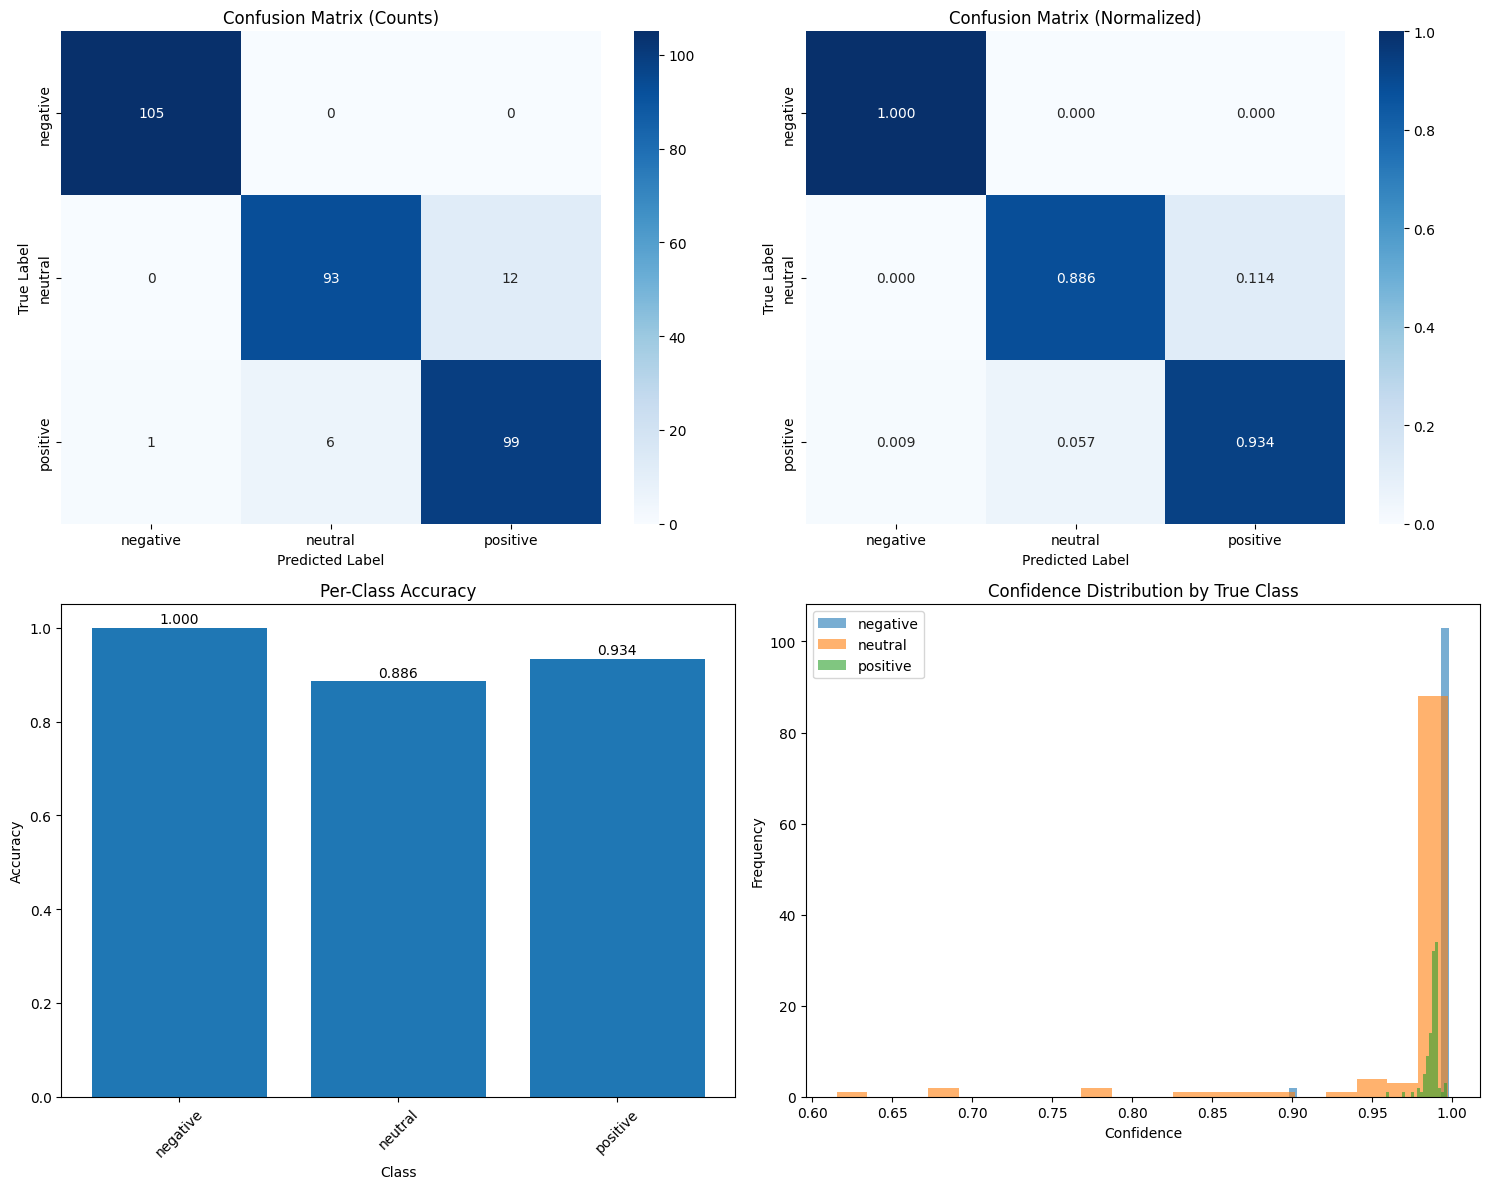


=== Detailed Classification Report ===
              precision    recall  f1-score   support

    negative     0.9906    1.0000    0.9953       105
     neutral     0.9394    0.8857    0.9118       105
    positive     0.8919    0.9340    0.9124       106

    accuracy                         0.9399       316
   macro avg     0.9406    0.9399    0.9398       316
weighted avg     0.9405    0.9399    0.9397       316


=== Overall Metrics ===
Overall Accuracy: 0.9399
Average Confidence: 0.9855

=== Per-Class Metrics ===
Class        Precision  Recall     F1-Score   Support    Avg_Confidence 
--------------------------------------------------------------------------------
negative     0.9906     1.0000     0.9953     105        0.9959         
neutral      0.9394     0.8857     0.9118     105        0.9727         
positive     0.8919     0.9340     0.9124     106        0.9879         

=== Macro Averages ===
Macro Precision: 0.9406
Macro Recall: 0.9399
Macro F1-Score: 0.9398

=== Weigh

In [ ]:
print("\n=== Final Evaluation ===")
eval_results = trainer.evaluate()
print(f"Final evaluation loss: {eval_results['eval_loss']:.4f}")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

def generate_predictions(model, dataset, tokenizer, device):
    """Generate predictions for the entire dataset"""
    model.eval()
    predictions = []
    true_labels = []
    confidences = []

    from torch.utils.data import DataLoader
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            predicted_classes = torch.argmax(probs, dim=1)
            max_probs = torch.max(probs, dim=1)[0]
            
            predictions.extend(predicted_classes.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(max_probs.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels), np.array(confidences)

print("Generating predictions for confusion matrix...")
val_predictions, val_true_labels, val_confidences = generate_predictions(model, val_dataset, tokenizer, device)

cm = confusion_matrix(val_true_labels, val_predictions)
class_names = label_encoder.classes_

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

cm_normalized = confusion_matrix(val_true_labels, val_predictions, normalize='true')
plt.subplot(2, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(2, 2, 3)
per_class_accuracy = cm_normalized.diagonal()
plt.bar(class_names, per_class_accuracy)
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.xticks(rotation=45)
for i, v in enumerate(per_class_accuracy):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.subplot(2, 2, 4)
for i, class_name in enumerate(class_names):
    class_confidences = val_confidences[val_true_labels == i]
    plt.hist(class_confidences, alpha=0.6, label=class_name, bins=20)
plt.title('Confidence Distribution by True Class')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Detailed classification report
print("\n=== Detailed Classification Report ===")
report = classification_report(val_true_labels, val_predictions, 
                             target_names=class_names, 
                             digits=4)
print(report)

accuracy = accuracy_score(val_true_labels, val_predictions)
precision, recall, f1, support = precision_recall_fscore_support(val_true_labels, val_predictions, 
                                                                average=None, labels=range(len(class_names)))

print(f"\n=== Overall Metrics ===")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Average Confidence: {np.mean(val_confidences):.4f}")

# Per-class detailed metrics
print(f"\n=== Per-Class Metrics ===")
print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10} {'Avg_Confidence':<15}")
print("-" * 80)
for i, class_name in enumerate(class_names):
    class_confidences = val_confidences[val_true_labels == i]
    avg_confidence = np.mean(class_confidences)
    print(f"{class_name:<12} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<10} {avg_confidence:<15.4f}")

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print(f"\n=== Macro Averages ===")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

print(f"\n=== Weighted Averages ===")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# Error analysis - find misclassified examples
print(f"\n=== Error Analysis ===")
misclassified_indices = np.where(val_predictions != val_true_labels)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")

# Show some misclassified examples
if len(misclassified_indices) > 0:
    print(f"\nSample misclassified examples:")
    sample_errors = np.random.choice(misclassified_indices, 
                                   min(5, len(misclassified_indices)), 
                                   replace=False)
    
    for idx in sample_errors:
        true_label = label_encoder.inverse_transform([val_true_labels[idx]])[0]
        pred_label = label_encoder.inverse_transform([val_predictions[idx]])[0]
        confidence = val_confidences[idx]
        text = val_texts[idx][:200] + "..." if len(val_texts[idx]) > 200 else val_texts[idx]
        
        print(f"\nText: {text}")
        print(f"True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.3f}")

print(f"\n=== Confidence Analysis ===")
print(f"High confidence (>0.9) predictions: {np.sum(val_confidences > 0.9)} ({np.sum(val_confidences > 0.9)/len(val_confidences)*100:.1f}%)")
print(f"Medium confidence (0.7-0.9) predictions: {np.sum((val_confidences >= 0.7) & (val_confidences <= 0.9))} ({np.sum((val_confidences >= 0.7) & (val_confidences <= 0.9))/len(val_confidences)*100:.1f}%)")
print(f"Low confidence (<0.7) predictions: {np.sum(val_confidences < 0.7)} ({np.sum(val_confidences < 0.7)/len(val_confidences)*100:.1f}%)")


high_conf_mask = val_confidences > 0.9
medium_conf_mask = (val_confidences >= 0.7) & (val_confidences <= 0.9)
low_conf_mask = val_confidences < 0.7

if np.sum(high_conf_mask) > 0:
    high_conf_accuracy = accuracy_score(val_true_labels[high_conf_mask], val_predictions[high_conf_mask])
    print(f"Accuracy for high confidence predictions: {high_conf_accuracy:.4f}")

if np.sum(medium_conf_mask) > 0:
    medium_conf_accuracy = accuracy_score(val_true_labels[medium_conf_mask], val_predictions[medium_conf_mask])
    print(f"Accuracy for medium confidence predictions: {medium_conf_accuracy:.4f}")

if np.sum(low_conf_mask) > 0:
    low_conf_accuracy = accuracy_score(val_true_labels[low_conf_mask], val_predictions[low_conf_mask])
    print(f"Accuracy for low confidence predictions: {low_conf_accuracy:.4f}")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def predict_sentiment_enhanced(text, return_probabilities=True):
    cleaned_text = clean_text_advanced(text)
    
    if not cleaned_text:
        return "neutral", [0.33, 0.33, 0.34] if return_probabilities else "neutral"
    
    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs.max().item()

    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    if return_probabilities:
        prob_dict = {label: prob for label, prob in zip(label_encoder.classes_, probs.tolist()[0])}
        return predicted_label, prob_dict, confidence
    else:
        return predicted_label

In [ ]:
test_texts = [
    "The demand for seafood raise to 100 per month. This will increase the growth of seafood sales",
    "The market is crashing and investors are losing money",
    "The company announced stable quarterly results"
]

In [61]:
print("\n=== Testing Enhanced Prediction Function ===")
for i, text in enumerate(test_texts):
    print(f"\nTest {i+1}: {text}")
    prediction, probs, confidence = predict_sentiment_enhanced(text)
    print(f"Predicted sentiment: {prediction}")
    print(f"Confidence: {confidence:.3f}")
    print(f"Probability distribution: {probs}")


=== Testing Enhanced Prediction Function ===

Test 1: The demand for seafood raise to 100 per month. This will increase the growth of seafood sales
Predicted sentiment: positive
Confidence: 0.937
Probability distribution: {'negative': 0.001721430802717805, 'neutral': 0.06102728471159935, 'positive': 0.9372512698173523}

Test 2: The market is crashing and investors are losing money
Predicted sentiment: negative
Confidence: 0.978
Probability distribution: {'negative': 0.977531909942627, 'neutral': 0.02099466882646084, 'positive': 0.0014734503347426653}

Test 3: The company announced stable quarterly results
Predicted sentiment: neutral
Confidence: 0.979
Probability distribution: {'negative': 0.0016087053809314966, 'neutral': 0.9791516065597534, 'positive': 0.019239695742726326}


In [62]:
# Save the model and tokenizer
print("\n=== Saving Model ===")
trainer.save_model("./saved_model_enhanced")
tokenizer.save_pretrained("./saved_model_enhanced")

print("Training completed successfully!")
print("Model saved to './saved_model_enhanced'")
print("Label encoder saved to 'label_encoder.pkl'")


=== Saving Model ===
Training completed successfully!
Model saved to './saved_model_enhanced'
Label encoder saved to 'label_encoder.pkl'
